In [1]:
import torch
import math
from torch import Tensor, FloatTensor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

import time
from evaluate import plot_different_histories, plot_4_different_histories

# generate datapoints and labels

In [2]:
def generate_all_datapoints_and_labels(number=1000):
    # generate 2d points 
    points = Tensor(number, 2)
    # uniform in (0,1)
    points=points.uniform_(0, 1)
    
    vector2center=points-Tensor([0.5,0.5])
    dist2center=vector2center.pow(2).sum(1)
    labels=[]
    for i in range(number):
        if dist2center[i]<=1/(2*math.pi):
            labels.append(1.)
        else:
            labels.append(0.)
    labels=Tensor(labels)
    return points, labels

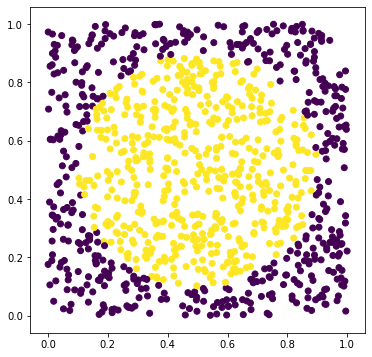

In [3]:
train_features, train_targets = generate_all_datapoints_and_labels()
test_features, test_targets = generate_all_datapoints_and_labels()
fig,axes = plt.subplots(1,1,figsize=(6,6))
axes.scatter(train_features[:,0], train_features[:,1], c=train_targets)
plt.show()

In [4]:
def convert_labels(labels):
    new_labels=Tensor(len(labels),2)
    for i in range(len(labels)):
        if labels[i]>0.5:
            new_labels[i]=Tensor([-1.,1.])
        else:
            new_labels[i]=Tensor([1.,-1.])
    return new_labels

In [5]:
train_labels, test_labels = convert_labels(train_targets), convert_labels(test_targets)

# Linear module

In [6]:
class Module (object) :
    def forward( self , x ) :
        raise NotImplementedError
        
    def backward( self , gradwrtoutput ) :
        raise NotImplementedError
        
    def param( self ) :
        return []

In [7]:
class Linear (Module) :
    
    # one fully-connected layer
    
    
    def __init__(self, in_dim, out_dim, eps=1., method='xavier'):
        self.in_dim=in_dim
        self.out_dim=out_dim
        
        # define weight, bias and their gradient
        self.w=FloatTensor(out_dim, in_dim)
        self.dw=FloatTensor(out_dim, in_dim)
        self.b=FloatTensor(out_dim)
        self.db=FloatTensor(out_dim)
        
        # initialization: defaulted as Xavier 
        if method=='zero':
            self.w=self.w.fill_(0)
            self.b=self.w.fill_(0)
        elif method=='normal':
            self.w=self.w.normal_(mean=0,std=eps)
            self.w=self.b.normal_(mean=0,std=eps)
        else:
            temp_std=1./math.sqrt((self.in_dim + self.out_dim)/2)
            self.w=self.w.normal_(mean=0,std=temp_std)
            self.b=self.b.normal_(mean=0,std=temp_std)
            
        # zero gradient intialization
        self.dw=self.dw.zero_()
        self.db=self.db.zero_()


    def forward( self ,x ):
        
        # y = w * x + b
        
        self.input=x.clone()
        self.output=self.w.matmul(self.input)+self.b
        #self.output=self.w @ self.input + self.b

        return self.output


        
    def backward( self , gradwrtoutput ):
        
        temp_wt=self.w.t()
       
        # dw = dL/dy * x
        temp_dw=gradwrtoutput.view(-1,1).mm(self.input.view(1,-1))
        self.dw.add_(temp_dw)
        
        # db = dL/dy
        temp_db=gradwrtoutput.clone()
        self.db.add_(temp_db)

        
        # dx = w.T * dL/dy
        temp_dx=temp_wt.matmul(gradwrtoutput)
        

        return temp_dx
        

        
    def param(self ) :      
        return [ self.w, self.dw  , self.b, self.db]
    
    
    def zero_grad(self):
        self.dw.zero_()
        self.db.zero_()

# Sequential Module

In [8]:
class Sequential(Module):
    def __init__(self, layers):
        self.layers=[]
        for temp_layer in layers:
            self.layers=self.layers+[temp_layer]
            
    def forward(self, x):
        self.input=x.clone()
        temp_output=self.input.clone()
        for temp_layer in self.layers:
            temp_output=temp_layer.forward(temp_output)
        final_output=temp_output
        return final_output
    
    def backward(self, gradwrtoutput):
        temp_gradient=gradwrtoutput.clone()
        for temp_layer in self.layers[::-1]:
            temp_gradient=temp_layer.backward(temp_gradient)
        final_gradient=temp_gradient
        return final_gradient
    
    def param(self):
        parameters=[temp_layer.param() for temp_layer in self.layers]
        return parameters
           

# Activation

## Relu

In [9]:
class ReLU(Module):
    def __init__(self):
        self.input=None
        
    def forward(self, x):
        # relu(x)= x (where input >=0) or 0 (where input <0)
        self.input=x.clone()
        temp_coef= (x>=0).float()
        output=x*temp_coef
        return output
    
    def backward(self, gradwrtoutput):
        # gradient = 1 (where input >=0) or 0 (where input < 0) 
        temp_coef= (self.input>=0).float()
        temp_grad=gradwrtoutput*(temp_coef)
        return temp_grad
        
        
    def param(self):
        return []

## Tanh

In [10]:
class Tanh(Module):
    def __init__(self):
        self.input=None
        
    def forward(self, x):
        self.input=x.clone()
        output= (x.exp() - (-x).exp()) / (x.exp() + (-x).exp())
        return output
    
    def backward(self, gradwrtoutput):
        temp_grad= 4./(  ( self.input.exp() + (-self.input).exp() ).pow(2)  )
        temp_grad=temp_grad*gradwrtoutput
        return temp_grad
    
    def param(self):
        return []
                 

## Sigmoid

In [11]:
class Sigmoid(Module):
    def __init__(self):
        self.input=None
     
    def forward(self, x):
        self.input=x.clone()
        output=1./(1+(-self.input).exp())
        return output
    
    def backward(self,gradwrtoutput ):
        temp_grad=(-self.input).exp()/( (1+(-self.input).exp()).pow(2) )
        temp_grad=temp_grad*gradwrtoutput
        return temp_grad
    
    def param(self):
        return []
        

## SeLU

In [12]:
class SeLU(Module):
    def __init__(self):
        self.input=None
        
    def forward(self, x):
        self.input=x.clone()
        output=x.clone()
        output[output<0]=output[output<0].exp()-1.
        return output
    
    def backward(self, gradwrtoutput):
        grad=self.input.clone()
        grad[grad>=0]=1.
        grad[grad<0]=grad[grad<0].exp()
        return grad * gradwrtoutput
        
        
    def param(self):
        return []

## Softmax

In [13]:
class Softmax(Module):
    def __init__(self):
        self.input=None
        
    def forward(self, x):
        self.input=x.clone()
        
        prob_pred=x.exp()
        prob_pred_sum=prob_pred.sum(0)
        self.output=prob_pred/prob_pred_sum
        
        return self.output
    
    def backward(self, gradwrtoutput):
        
        prob_pred=self.input.exp()
        prob_pred_sum=prob_pred.sum(0)
        grad=(prob_pred_sum-prob_pred)/(prob_pred_sum.pow(2))
        
        return grad * gradwrtoutput
        
        
    def param(self):
        return []

# Optimizer

## SGD

In [14]:
class SGD():
    def __init__(self, model,lr=1e-3, momentum=0.):
        self.lr=lr
        self.layers=model.layers
        self.momentum=momentum
        
    def step(self):
        for temp_layer in self.layers:
            temp_param=temp_layer.param()
            if len(temp_param)>0:
                _ , temp_dw, _ , temp_db = temp_param
                temp_layer.w=temp_layer.w-self.lr*temp_dw
                temp_layer.b=temp_layer.b-self.lr*temp_db
                
    def zero_grad(self):
        for temp_layer in self.layers:
            try:
                temp_layer.zero_grad()
            except:
                continue

## ADAM

In [15]:
class Adam():
    def __init__(self, model,lr=1e-3, beta_1=0.9, beta_2=0.999, eps=1e-8 ):
        self.lr=lr
        self.beta_1=beta_1
        self.beta_2=beta_2
        self.eps=eps
        self.layers=model.layers
        self.time=0
        
        self.num_grad=0
        
        self.m=[]
        self.v=[]
        for temp_layer in self.layers:
            temp_param=temp_layer.param()
            if (len(temp_param))>0:
                
                self.m.append(Tensor(temp_param[1].size()).zero_())
                self.m.append(Tensor(temp_param[3].size()).zero_())
                self.v.append(Tensor(temp_param[1].size()).zero_())
                self.v.append(Tensor(temp_param[3].size()).zero_())
                self.num_grad+=2

                               
    def step(self):
        i=0
        for temp_layer in self.layers:
            temp_param=temp_layer.param()
            if len(temp_param)>0:
                _ , temp_dw, _ , temp_db = temp_param
                # update weight
                self.m[i]=self.beta_1*self.m[i]+(1-self.beta_1)*temp_dw
                self.v[i]=self.beta_2*self.v[i]+(1-self.beta_2)*(temp_dw.pow(2))
                temp_m_hat=self.m[i]/(1-self.beta_1**(self.time+1))
                temp_v_hat=self.v[i]/(1-self.beta_2**(self.time+1))
                temp_layer.w-=self.lr*temp_m_hat/(temp_v_hat.pow(0.5)+self.eps)
                
                # update bias
                self.m[i+1]=self.beta_1*self.m[i+1]+(1-self.beta_1)*temp_db
                self.v[i+1]=self.beta_2*self.v[i+1]+(1-self.beta_2)*(temp_db.pow(2))
                temp_m_hat=self.m[i+1]/(1-self.beta_1**(self.time+1))
                temp_v_hat=self.v[i+1]/(1-self.beta_2**(self.time+1))
                temp_layer.b-=self.lr*temp_m_hat/(temp_v_hat.pow(0.5)+self.eps)
                
                i+=2
                
        self.time+=1
                
                
    def zero_grad(self):
        for temp_layer in self.layers:
            try:
                temp_layer.zero_grad()
            except:
                continue

# Regularization

## Dropout

In [16]:
class Dropout(Module):
    def __init__(self, p=0.5):
        self.p=p
        self.prob_matrix=None
        
    def forward(self,x):
        self.prob_matrix=Tensor(x.size())
        self.prob_matrix=self.prob_matrix.bernoulli_(1.-self.p).div_(1.-self.p)
        return x * self.prob_matrix
    
    def backward(self,gradwrtoutput):
        return gradwrtoutput*self.prob_matrix.t()
    
    def param(self):
        return []
              

# Loss function

## MSE

In [17]:
class LossMSE():
    def __init__(self):
        self.pred=None
        self.label=None
        
    def forward(self, pred, label):
        self.pred=pred.clone()
        self.label=label.clone()
        all_loss=(self.label - self.pred).pow(2)
        mse=all_loss.mean()
        return mse
    
    def backward(self, pred, label):
        self.pred=pred
        self.label=label
        grad=2*(self.label - self.pred)*(-1)
        return grad
        
    def param(self):
        return []

## MAE

In [18]:
class LossMAE():
    def __init__(self):
        self.pred=None
        self.label=None
        
    def forward(self, pred, label):
        self.pred=pred.clone()
        self.label=label.clone()
        all_loss=(self.label - self.pred).abs()
        mae=all_loss.mean()
        return mae
    
    def backward(self, pred, label):
        self.pred=pred
        self.label=label
        grad=pred
        grad[grad>=self.pred]=1.
        grad[grad<self.pred]=-1.
        return grad
        
    def param(self):
        return []

## Cross entropy

In [19]:
class CrossEntropy():
    def __init__(self):
        self.pred=None
        self.label=None
        
    def forward(self, pred, label, eps=1e-2):
        self.pred=pred
        self.label=label
        self.eps=eps
        
        prob_label=Tensor(label.size()).zero_()
        _,label_class=torch.max(label,0)
        prob_label[label_class]=1.
        
        pred.add_(eps)
        entropys=-(pred.log())*prob_label
        self.output=entropys.sum(0)
        return self.output
    
    
    def backward(self, pred, label, eps=1e-2):
        self.pred=pred
        self.label=label
        self.eps=eps
        #prob_pred=pred.softmax(0)
        
        prob_label=FloatTensor(label.size()).zero_()
        _,label_class=torch.max(label,0)
        prob_label[label_class]=1.
        
        #grad=-prob_label/pred
      
        grad=FloatTensor(pred.size()).zero_()

        grad[0]=-prob_label[0]/(pred[0]+eps)+prob_label[1]/(1-pred[0]+eps)
        grad[1]=-prob_label[1]/(pred[1]+eps)+prob_label[0]/(1-pred[1]+eps)

 
        return grad
    
        
    def param(self):
        return []

# Train with my modules

In [20]:
torch.set_grad_enabled(False)

## model 1

In [48]:
my_model_design=[Linear(2,25), ReLU(), Linear(25,25), ReLU(),
                   Linear(25,25), ReLU(),Linear(25,2),Tanh()]
my_model=Sequential(my_model_design)
optimizer=SGD(my_model,lr=1e-3)
criterion=LossMSE()

batch_size=1

my_model_1_train_loss=[]
my_model_1_train_accuracy=[]
my_model_1_test_loss=[]
my_model_1_test_accuracy=[]


start_time=time.time()

for epoch in range(30):
    temp_train_loss_sum=0.
    temp_test_loss_sum=0.
    num_train_correct=0
    num_test_correct=0
    
    for temp_batch in range(0,len(train_features), batch_size):
        temp_train_features=train_features.narrow(0, temp_batch, batch_size)  
        temp_train_labels=train_labels.narrow(0, temp_batch, batch_size)  
        
        for i in range(batch_size):
            optimizer.zero_grad()  
            temp_train_feature=temp_train_features[i]
            temp_train_label=temp_train_labels[i]
            
            temp_train_pred=my_model.forward(temp_train_feature)
            temp_train_loss=criterion.forward(temp_train_pred,temp_train_label)
            temp_train_loss_sum+=temp_train_loss
            
            _, temp_train_pred_cat=torch.max(temp_train_pred,0)
            _, temp_train_label_cat=torch.max(temp_train_label,0)

            
            if temp_train_pred_cat==temp_train_label_cat:
                num_train_correct+=1
            
            
            
            temp_train_loss_grad=criterion.backward(temp_train_pred,temp_train_label)
            my_model.backward(temp_train_loss_grad)                       
        
        optimizer.step()
        
    for i_test in range(len(test_features)):
        temp_test_feature=test_features[i_test]
        temp_test_label=test_labels[i_test]

        temp_test_pred=my_model.forward(temp_test_feature)
        temp_test_loss=criterion.forward(temp_test_pred,temp_test_label)
        temp_test_loss_sum+=temp_test_loss

        
        _, temp_test_pred_cat=torch.max(temp_test_pred,0)
        _, temp_test_label_cat=torch.max(temp_test_label,0)

        if temp_test_pred_cat==temp_test_label_cat:
            num_test_correct+=1
        
        
    temp_train_loss_mean=temp_train_loss_sum/len(train_features)
    temp_test_loss_mean=temp_test_loss_sum/len(test_features)
    
    temp_train_accuracy=num_train_correct/len(train_features)
    temp_test_accuracy=num_test_correct/len(test_features)
    
    my_model_1_train_loss.append(temp_train_loss_mean)
    my_model_1_train_accuracy.append(temp_train_accuracy)
    my_model_1_test_loss.append(temp_test_loss_mean)
    my_model_1_test_accuracy.append(temp_test_accuracy)
    
    
    print("Epoch: {}/{}..".format(epoch+1, 30),
                  "Training Loss: {:.4f}..".format(temp_train_loss_mean),
                  "Training Accuracy: {:.4f}..".format(temp_train_accuracy), 
                  "Validation/Test Loss: {:.4f}..".format(temp_test_loss_mean),
                  "Validation/Test Accuracy: {:.4f}..".format(temp_test_accuracy),  )
       
end_time=time.time()
total_time=end_time - start_time
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('Final accuracy on testing set: ' + str(format((my_model_1_test_accuracy[-1]),'.3f')))
print('Total time spent on 30 epochs of training:: ' + str(format((total_time),'.2f'))+'s')

Epoch: 1/30.. Training Loss: 1.0135.. Training Accuracy: 0.5490.. Validation/Test Loss: 0.9812.. Validation/Test Accuracy: 0.6380..
Epoch: 2/30.. Training Loss: 0.9777.. Training Accuracy: 0.6040.. Validation/Test Loss: 0.9672.. Validation/Test Accuracy: 0.6530..
Epoch: 3/30.. Training Loss: 0.9626.. Training Accuracy: 0.6410.. Validation/Test Loss: 0.9492.. Validation/Test Accuracy: 0.6760..
Epoch: 4/30.. Training Loss: 0.9436.. Training Accuracy: 0.6560.. Validation/Test Loss: 0.9238.. Validation/Test Accuracy: 0.7010..
Epoch: 5/30.. Training Loss: 0.9135.. Training Accuracy: 0.6920.. Validation/Test Loss: 0.8845.. Validation/Test Accuracy: 0.7330..
Epoch: 6/30.. Training Loss: 0.8710.. Training Accuracy: 0.7250.. Validation/Test Loss: 0.8282.. Validation/Test Accuracy: 0.7600..
Epoch: 7/30.. Training Loss: 0.8062.. Training Accuracy: 0.7740.. Validation/Test Loss: 0.7426.. Validation/Test Accuracy: 0.7970..
Epoch: 8/30.. Training Loss: 0.7088.. Training Accuracy: 0.8180.. Validation

## model 2

In [44]:
my_model_design=[Linear(2,25), ReLU(), Linear(25,25), Dropout(p=0.5), SeLU(),
                   Linear(25,25),Dropout(p=0.5), ReLU(),Linear(25,2),Softmax()]
my_model=Sequential(my_model_design)
optimizer=Adam(my_model,lr=1e-3)
criterion=CrossEntropy()

batch_size=1
epoch=0

start_time=time.time()

my_model_2_train_loss=[]
my_model_2_train_accuracy=[]
my_model_2_test_loss=[]
my_model_2_test_accuracy=[]

while(epoch<30):
    temp_train_loss_sum=0.
    temp_test_loss_sum=0.
    num_train_correct=0
    num_test_correct=0
    
    for temp_batch in range(0,len(train_features), batch_size):
        temp_train_features=train_features.narrow(0, temp_batch, batch_size)  
        temp_train_labels=train_labels.narrow(0, temp_batch, batch_size)  
        
        for i in range(batch_size):
            optimizer.zero_grad()  
            temp_train_feature=temp_train_features[i]
            temp_train_label=temp_train_labels[i]
            
            temp_train_pred=my_model.forward(temp_train_feature)
            temp_train_loss=criterion.forward(temp_train_pred,temp_train_label)
            temp_train_loss_sum+=temp_train_loss
            
            _, temp_train_pred_cat=torch.max(temp_train_pred,0)
            _, temp_train_label_cat=torch.max(temp_train_label,0)

            
            if temp_train_pred_cat==temp_train_label_cat:
                num_train_correct+=1
            
            
            
            
            temp_train_loss_grad=criterion.backward(temp_train_pred,temp_train_label)
            '''
            if (not temp_train_loss_grad[0]>=0) and (not temp_train_loss_grad[0]<0):
                continue
            '''
            my_model.backward(temp_train_loss_grad)     
            
        
        
        optimizer.step()
        
    for i_test in range(len(test_features)):
        temp_test_feature=test_features[i_test]
        temp_test_label=test_labels[i_test]

        temp_test_pred=my_model.forward(temp_test_feature)
        temp_test_loss=criterion.forward(temp_test_pred,temp_test_label)
        temp_test_loss_sum+=temp_test_loss

        
        _, temp_test_pred_cat=torch.max(temp_test_pred,0)
        _, temp_test_label_cat=torch.max(temp_test_label,0)

        if temp_test_pred_cat==temp_test_label_cat:
            num_test_correct+=1
        
        
    temp_train_loss_mean=temp_train_loss_sum/len(train_features)
    temp_test_loss_mean=temp_test_loss_sum/len(test_features)
    
    temp_train_accuracy=num_train_correct/len(train_features)
    temp_test_accuracy=num_test_correct/len(test_features)
    
    if (not temp_train_loss_grad[0]>=0) and (not temp_train_loss_grad[0]<0):
        epoch=0
        my_model_design=[Linear(2,25), ReLU(), Linear(25,25), Dropout(p=0.5), ReLU(),
                   Linear(25,25),Dropout(p=0.5), ReLU(),Linear(25,2),Sigmoid()]
        my_model=Sequential(my_model_design)
        optimizer=Adam(my_model,lr=1e-3)
        criterion=CrossEntropy()
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('--------------------------------------------------------------------------------')
        print('Restart training because of gradient explosion')
        
        my_model_2_train_loss=[]
        my_model_2_train_accuracy=[]
        my_model_2_test_loss=[]
        my_model_2_test_accuracy=[]
        
        start_time=time.time()
        
        continue
    
    print("Epoch: {}/{}..".format(epoch+1, 30),
                  "Training Loss: {:.4f}..".format(temp_train_loss_mean),
                  "Training Accuracy: {:.4f}..".format(temp_train_accuracy), 
                  "Validation/Test Loss: {:.4f}..".format(temp_test_loss_mean),
                  "Validation/Test Accuracy: {:.4f}..".format(temp_test_accuracy),  )
    epoch+=1 
    my_model_2_train_loss.append(temp_train_loss_mean)
    my_model_2_train_accuracy.append(temp_train_accuracy)
    my_model_2_test_loss.append(temp_test_loss_mean)
    my_model_2_test_accuracy.append(temp_test_accuracy)
    
end_time=time.time()
total_time=end_time - start_time
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('Final accuracy on testing set: ' + str(format((my_model_2_test_accuracy[-1]),'.3f')))
print('Total time spent on 30 epochs of training:: ' + str(format((total_time),'.2f'))+'s')    

Epoch: 1/30.. Training Loss: 0.6903.. Training Accuracy: 0.5220.. Validation/Test Loss: 0.6660.. Validation/Test Accuracy: 0.5510..
Epoch: 2/30.. Training Loss: 0.6361.. Training Accuracy: 0.6170.. Validation/Test Loss: 0.6165.. Validation/Test Accuracy: 0.6350..
Epoch: 3/30.. Training Loss: 0.5689.. Training Accuracy: 0.6960.. Validation/Test Loss: 0.5301.. Validation/Test Accuracy: 0.7180..
Epoch: 4/30.. Training Loss: 0.4720.. Training Accuracy: 0.7670.. Validation/Test Loss: 0.4464.. Validation/Test Accuracy: 0.7920..
Epoch: 5/30.. Training Loss: 0.3796.. Training Accuracy: 0.8210.. Validation/Test Loss: 0.3572.. Validation/Test Accuracy: 0.8370..
Epoch: 6/30.. Training Loss: 0.3091.. Training Accuracy: 0.8610.. Validation/Test Loss: 0.2793.. Validation/Test Accuracy: 0.8720..
Epoch: 7/30.. Training Loss: 0.2806.. Training Accuracy: 0.8760.. Validation/Test Loss: 0.2153.. Validation/Test Accuracy: 0.9050..
Epoch: 8/30.. Training Loss: 0.2263.. Training Accuracy: 0.9000.. Validation

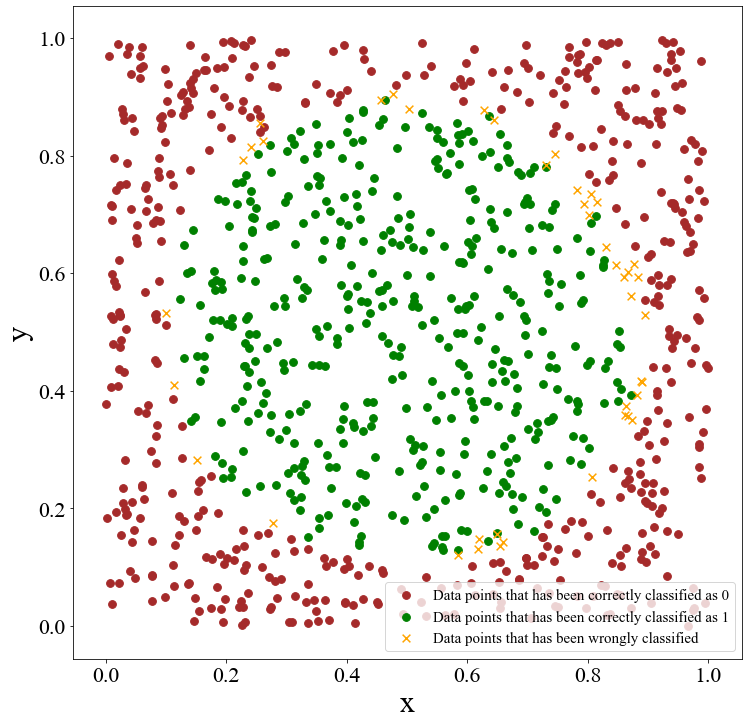

In [25]:
# import numpy here only to help visualize the classification performance (not used anywhere else)
import numpy as np
test_pred_labels=[]
for i in range(1000): 
    temp_test_feature=test_features[i]
    temp_test_label=test_labels[i]

    temp_test_pred=my_model.forward(temp_test_feature)

    _, temp_train_pred_cat=torch.max(temp_test_pred,0)
    if test_targets[i].int() == temp_train_pred_cat.int():
        test_pred_labels.append(int(test_targets[i]))
    else:
        test_pred_labels.append(2)
test_pred_labels=np.array(test_pred_labels)
fig,axes = plt.subplots(1,1,figsize=(12,12))
index_0=np.where(test_pred_labels==0)
index_1=np.where(test_pred_labels==1)
index_2=np.where(test_pred_labels==2)
axes.scatter(test_features[index_0][:,0], test_features[index_0][:,1],c='brown',s=60)
axes.scatter(test_features[index_1][:,0], test_features[index_1][:,1],c='g',s=60)
axes.scatter(test_features[index_2][:,0], test_features[index_2][:,1],c='orange',marker='x',s=60)
legends=['Data points that has been correctly classified as 0',
        'Data points that has been correctly classified as 1',
        'Data points that has been wrongly classified']
font2 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 30,
}
font1 = {'family': 'Times New Roman',
         'weight': 'normal',
         'size': 15,
         }
axes.legend(legends,prop=font1)
axes.tick_params(labelsize=22)
axes.set_xlabel('x',font2)
axes.set_ylabel('y',font2)
labels = axes.get_xticklabels() + axes.get_yticklabels()
[label.set_fontname('Times New Roman') for label in labels]
plt.show()

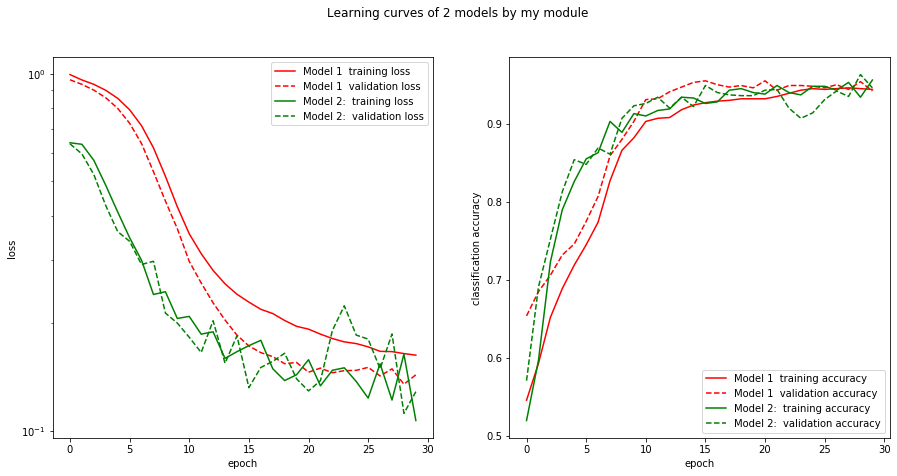

In [28]:
plot_different_histories(my_model_1_train_loss,my_model_1_train_accuracy, my_model_1_test_loss,my_model_1_test_accuracy,
                             my_model_2_train_loss,my_model_2_train_accuracy, my_model_2_test_loss, my_model_2_test_accuracy,
                             label_1='Model 1 ',label_2='Model 2: ',title='Learning curves of 2 models by my module')

# Comparison with Torch Modules

In [23]:
import torch
from torch import nn, optim 
from torch.nn import functional as F 
from torch.autograd import Variable
import torch
import math
from torch import optim
from torch import Tensor
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [24]:
torch.set_grad_enabled(True)

## model 1

In [40]:
start_time=time.time()

model = nn.Sequential(
        nn.Linear(2,25),
        nn.ReLU(),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.Linear(25,25),
        nn.ReLU(),
        nn.Linear(25,2),
        nn.Tanh(),
)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3)
train_input=train_features
#train_target=train_targets.long()
train_target=train_labels
#train_target=train_targets
test_input=test_features
#test_target=test_targets.long()
test_target=test_labels
#test_target=test_targets
batch_size=1

torch_model_1_train_loss=[]
torch_model_1_train_accuracy=[]
torch_model_1_test_loss=[]
torch_model_1_test_accuracy=[]

for e in range(30):
        for b in range(0, train_input.size(0), batch_size):
            temp_train_input=train_input.narrow(0, b, batch_size)    
            temp_train_target=train_target.narrow(0, b, batch_size)
            train_output = model(temp_train_input)
            loss = criterion(train_output, temp_train_target)
            model.zero_grad()
            loss.backward()
            optimizer.step()
                
        train_temp_output = model(train_input)
        train_temp_loss = criterion(train_temp_output, train_target)
        _, temp_train_pred =torch.max(F.softmax(train_temp_output).data, 1)
        _, temp_train_label =torch.max(F.softmax(train_target).data, 1)
        train_temp_accuracy=((temp_train_pred == temp_train_label).sum().item())/train_input.size(0)
        
        test_temp_output=model(test_input)
        test_temp_loss = criterion(test_temp_output, test_target)
        _, temp_test_pred =torch.max(F.softmax(test_temp_output).data, 1)
        _, temp_test_label =torch.max(F.softmax(test_target).data, 1)
        test_temp_accuracy=((temp_test_pred == temp_test_label).sum().item())/test_input.size(0)
        
        #train_loss_list=train_loss_list+[train_temp_loss]
        #train_accuracy_list=train_accuracy_list+[train_temp_accuracy]
        #test_loss_list=test_loss_list+[test_temp_loss]
        #test_accuracy_list=test_accuracy_list+[test_temp_accuracy]
        
        print("Epoch: {}/{}..".format(e+1, 30),
                  "Training Loss: {:.4f}..".format(train_temp_loss),
                  "Training Accuracy: {:.4f}..".format(train_temp_accuracy), 
                  "Validation Loss: {:.4f}..".format(test_temp_loss),
                  "Validation Accuracy: {:.4f}..".format(test_temp_accuracy),  )
        
        torch_model_1_train_loss.append(train_temp_loss)
        torch_model_1_train_accuracy.append(train_temp_accuracy)
        torch_model_1_test_loss.append(test_temp_loss)
        torch_model_1_test_accuracy.append(test_temp_accuracy)
        
end_time=time.time()
total_time=end_time-start_time

print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('Final accuracy on testing set: ' + str(format((torch_model_1_test_accuracy[-1]),'.3f')))
print('Total time spent on 30 epochs of training:: ' + str(format((total_time),'.2f'))+'s')

Epoch: 1/30.. Training Loss: 0.9949.. Training Accuracy: 0.5600.. Validation Loss: 0.9975.. Validation Accuracy: 0.5390..
Epoch: 2/30.. Training Loss: 0.9921.. Training Accuracy: 0.5840.. Validation Loss: 0.9949.. Validation Accuracy: 0.5660..
Epoch: 3/30.. Training Loss: 0.9904.. Training Accuracy: 0.6040.. Validation Loss: 0.9933.. Validation Accuracy: 0.5800..
Epoch: 4/30.. Training Loss: 0.9888.. Training Accuracy: 0.6080.. Validation Loss: 0.9919.. Validation Accuracy: 0.5890..
Epoch: 5/30.. Training Loss: 0.9870.. Training Accuracy: 0.6100.. Validation Loss: 0.9904.. Validation Accuracy: 0.5900..
Epoch: 6/30.. Training Loss: 0.9847.. Training Accuracy: 0.6020.. Validation Loss: 0.9884.. Validation Accuracy: 0.5960..
Epoch: 7/30.. Training Loss: 0.9823.. Training Accuracy: 0.6030.. Validation Loss: 0.9862.. Validation Accuracy: 0.5950..
Epoch: 8/30.. Training Loss: 0.9795.. Training Accuracy: 0.6100.. Validation Loss: 0.9837.. Validation Accuracy: 0.5940..
Epoch: 9/30.. Training L

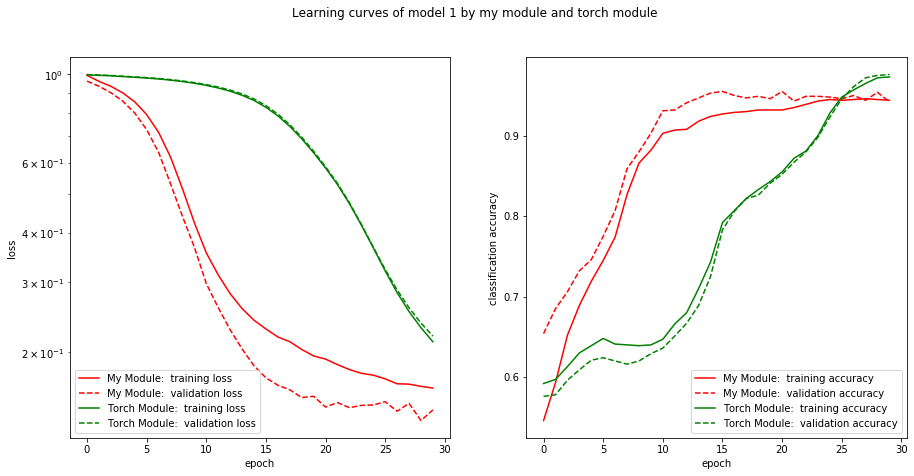

In [36]:
plot_different_histories(my_model_1_train_loss,my_model_1_train_accuracy, my_model_1_test_loss,my_model_1_test_accuracy,
                             torch_model_1_train_loss,torch_model_1_train_accuracy, torch_model_1_test_loss,torch_model_1_test_accuracy,
                             label_1='My Module: ', label_2='Torch Module: ', 
                         title='Learning curves of model 1 by my module and torch module')

## model 2

In [25]:
start_time=time.time()

model = nn.Sequential(
        nn.Linear(2,25),
        nn.ReLU(),
        nn.Linear(25,25),
        nn.Dropout(p=0.5),
        nn.ELU(),
        nn.Linear(25,25),
        nn.Dropout(p=0.5),
        nn.ReLU(),
        nn.Linear(25,2),
        nn.Softmax(),
)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
train_input=train_features
train_target=train_targets.long()
#train_target=train_labels
test_input=test_features
test_target=test_targets.long()
#test_target=test_labels
batch_size=1

torch_model_2_train_loss=[]
torch_model_2_train_accuracy=[]
torch_model_2_test_loss=[]
torch_model_2_test_accuracy=[]

for e in range(30):
        for b in range(0, train_input.size(0), batch_size):
            temp_train_input=train_input.narrow(0, b, batch_size)    
            temp_train_target=train_target.narrow(0, b, batch_size)
            train_output = model(temp_train_input)
            loss = criterion(train_output, temp_train_target)
            model.zero_grad()
            loss.backward()
            optimizer.step()
                
        train_temp_output = model(train_input)
        train_temp_loss = criterion(train_temp_output, train_target)
        _, temp_train_pred =torch.max(F.softmax(train_temp_output).data, 1)
        train_temp_accuracy=((temp_train_pred == train_target).sum().item())/train_input.size(0)
        
        test_temp_output=model(test_input)
        test_temp_loss = criterion(test_temp_output, test_target)
        _, temp_test_pred =torch.max(F.softmax(test_temp_output).data, 1)
        test_temp_accuracy=((temp_test_pred == test_target).sum().item())/test_input.size(0)
        
        #train_loss_list=train_loss_list+[train_temp_loss]
        #train_accuracy_list=train_accuracy_list+[train_temp_accuracy]
        #test_loss_list=test_loss_list+[test_temp_loss]
        #test_accuracy_list=test_accuracy_list+[test_temp_accuracy]
        
        print("Epoch: {}/{}..".format(e+1, 30),
                  "Training Loss: {:.4f}..".format(train_temp_loss),
                  "Training Accuracy: {:.4f}..".format(train_temp_accuracy), 
                  "Validation Loss: {:.4f}..".format(test_temp_loss),
                  "Validation Accuracy: {:.4f}..".format(test_temp_accuracy),  )
        
        
        torch_model_2_train_loss.append(train_temp_loss)
        torch_model_2_train_accuracy.append(train_temp_accuracy)
        torch_model_2_test_loss.append(test_temp_loss)
        torch_model_2_test_accuracy.append(test_temp_accuracy)
        
        
end_time=time.time()
total_time=end_time-start_time

print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('****************************************************************************')
print('Final accuracy on testing set: ' + str(format((torch_model_2_test_accuracy[-1]),'.3f')))
print('Total time spent on 30 epochs of training:: ' + str(format((total_time),'.2f'))+'s')

Epoch: 1/30.. Training Loss: 0.6895.. Training Accuracy: 0.5340.. Validation Loss: 0.6883.. Validation Accuracy: 0.5440..
Epoch: 2/30.. Training Loss: 0.6227.. Training Accuracy: 0.7160.. Validation Loss: 0.6179.. Validation Accuracy: 0.7370..
Epoch: 3/30.. Training Loss: 0.5139.. Training Accuracy: 0.8200.. Validation Loss: 0.5147.. Validation Accuracy: 0.8110..
Epoch: 4/30.. Training Loss: 0.4641.. Training Accuracy: 0.8480.. Validation Loss: 0.4624.. Validation Accuracy: 0.8540..
Epoch: 5/30.. Training Loss: 0.4349.. Training Accuracy: 0.8750.. Validation Loss: 0.4380.. Validation Accuracy: 0.8810..
Epoch: 6/30.. Training Loss: 0.4036.. Training Accuracy: 0.9100.. Validation Loss: 0.3999.. Validation Accuracy: 0.9230..
Epoch: 7/30.. Training Loss: 0.3798.. Training Accuracy: 0.9430.. Validation Loss: 0.3928.. Validation Accuracy: 0.9290..
Epoch: 8/30.. Training Loss: 0.3895.. Training Accuracy: 0.9200.. Validation Loss: 0.3948.. Validation Accuracy: 0.9110..
Epoch: 9/30.. Training L

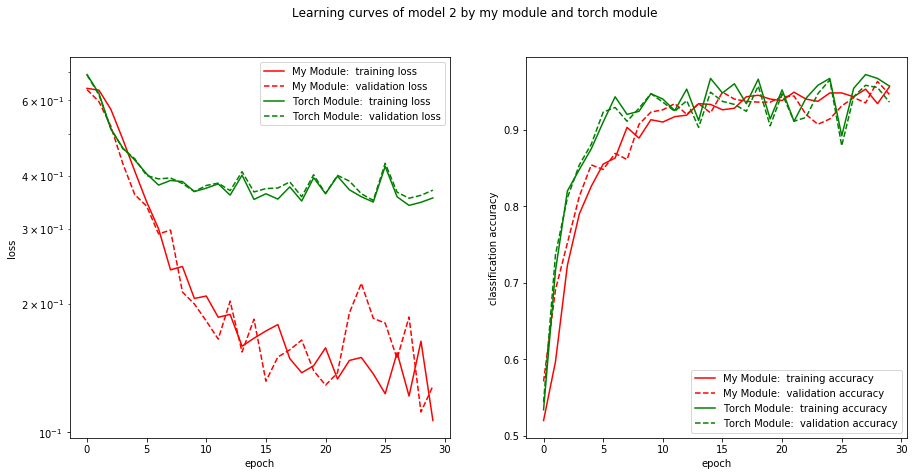

In [26]:
plot_different_histories(my_model_2_train_loss,my_model_2_train_accuracy, my_model_2_test_loss,my_model_2_test_accuracy,
                             torch_model_2_train_loss,torch_model_2_train_accuracy, torch_model_2_test_loss,torch_model_2_test_accuracy,
                             label_1='My Module: ', label_2='Torch Module: ', 
                         title='Learning curves of model 2 by my module and torch module')

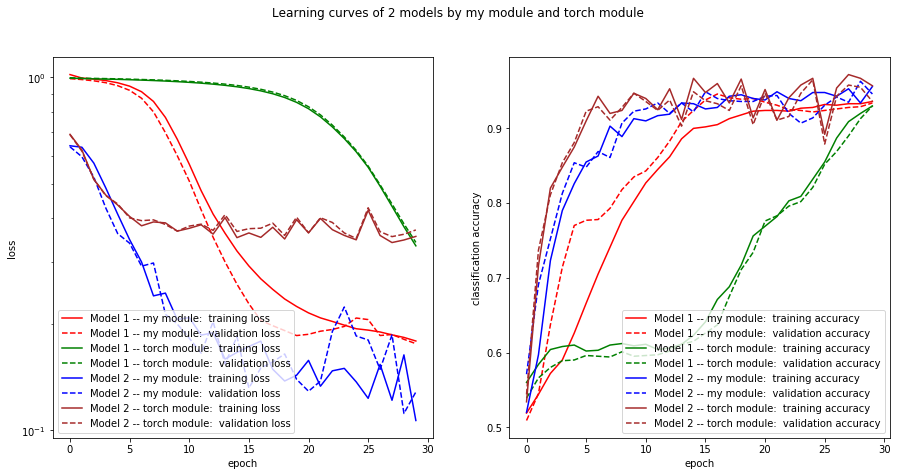

In [45]:
plot_4_different_histories(my_model_1_train_loss,my_model_1_train_accuracy, my_model_1_test_loss,my_model_1_test_accuracy,
                             torch_model_1_train_loss,torch_model_1_train_accuracy, torch_model_1_test_loss,torch_model_1_test_accuracy,
                             my_model_2_train_loss,my_model_2_train_accuracy, my_model_2_test_loss,my_model_2_test_accuracy,
                             torch_model_2_train_loss,torch_model_2_train_accuracy, torch_model_2_test_loss,torch_model_2_test_accuracy,
                             label_1='Model 1 -- my module: ', label_2='Model 1 -- torch module: ', 
                           label_3='Model 2 -- my module: ', label_4='Model 2 -- torch module: ', 
                         title='Learning curves of 2 models by my module and torch module')